In [1]:
import os
import warnings
import time
from copy import deepcopy

import numpy as np 

from scipy.stats import chisquare
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures, angular_to_pixel
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments
from lcbg.photometry import flux_to_abmag, order_cat
from lcbg.cosmology import cosmo_aperture_diameter


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Do Aperture Photomerty

In [7]:
current_filter =  filter_list[0]
input_data_path = input_data_formatter.format(current_filter)
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

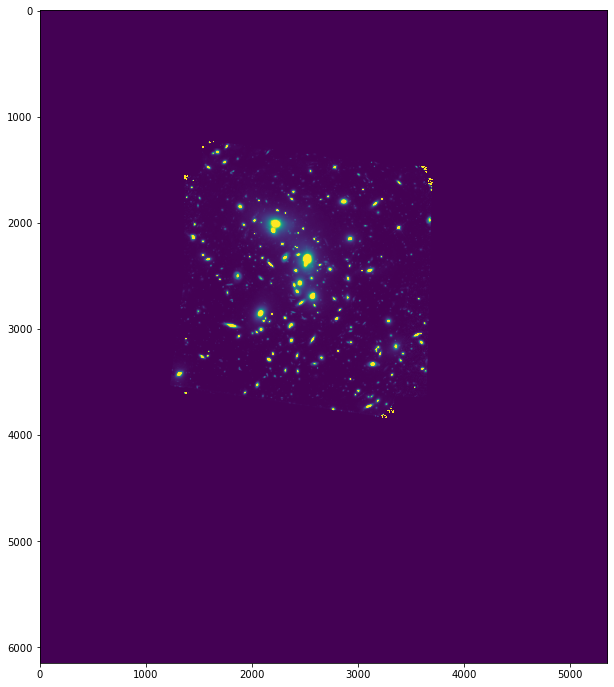

In [8]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

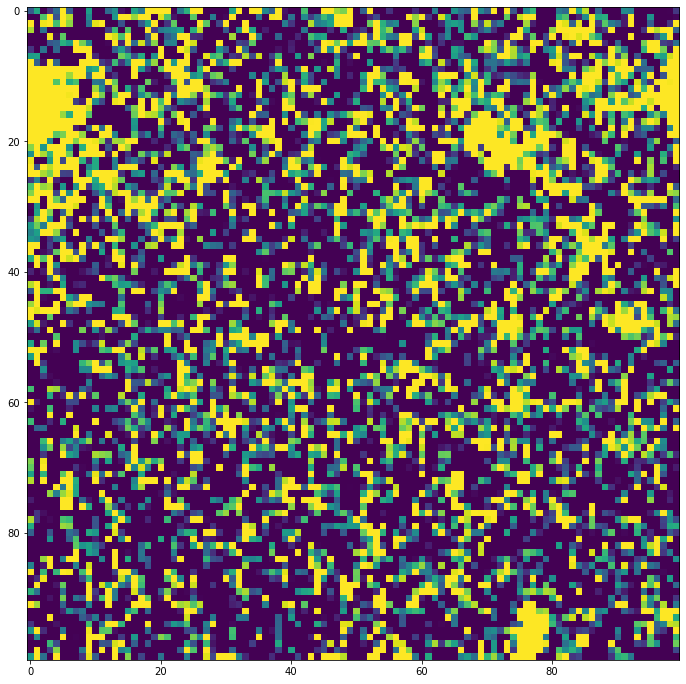

In [9]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2779, 3390), 100)

noise_mean = noise_cutout.data.mean()
noise_3_sigma = np.unique(detect_threshold(noise_cutout.data, nsigma=3))[0] # Single value
noise_8_sigma = np.unique(detect_threshold(noise_cutout.data, nsigma=8))[0] # Single value

plt.imshow(noise_cutout.data, vmax=noise_cutout.data.mean()*10, vmin=0)

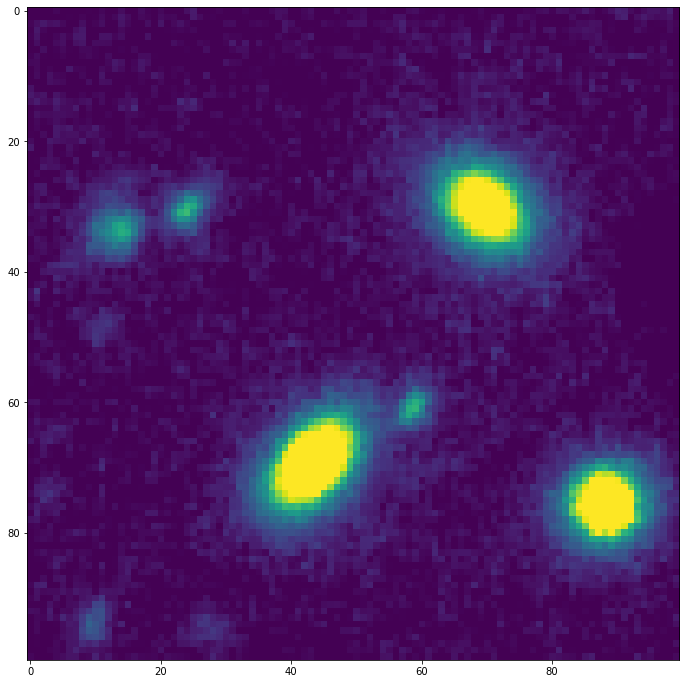

In [10]:
# Cutout Image
# -------------
# Select and crop image:
# Center of cluster:
# cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]

# Cutom center:
cx, cy = 2864, 3563

image = Cutout2D(data, (cx, cy), 100)
image.data -= noise_mean
image.data = np.clip(image.data, 0, image.data.max())

vmin = 0
vmax = image.data.mean()*10

plt.imshow(image.data, vmin=vmin, vmax=vmax)

6


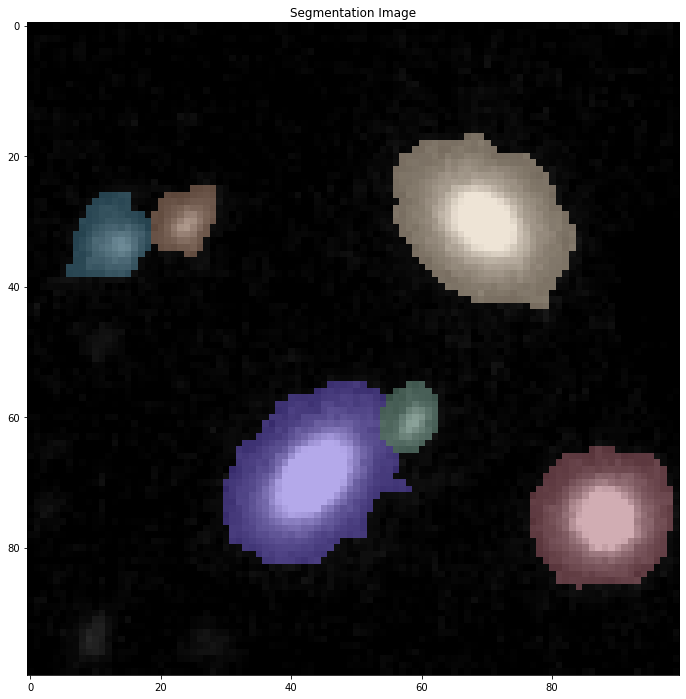

In [11]:
# Catalog
# -------

# Define detect threshold
#nsigma = np.zeros_like(image) + image.data.mean() 
#nsigma = np.unique(detect_threshold(image.data, nsigma=1))[0]
nsigma = noise_3_sigma
#nsigma = noise_8_sigma

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, kernel_size=4, fwhm=5, npixels=100)

# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, kernel_size=4, fwhm=5, npixels=15)

# Remove border sources
#segm_deblend.remove_border_labels(5)

# Make catalog
cat = source_properties(image.data, segm_deblend, wcs=image.wcs)
print(len(cat))

plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.show()



In [12]:
def segm_mask(obj, image, segm_deblend):
    mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == obj.id))
    return mask 

def masked_segm_image(obj, image, segm_deblend, fill=None):
    fill = np.nan if fill is None else fill
    mask = segm_mask(obj, image, segm_deblend)
    
    masked_image = deepcopy(image)
    masked_image.data[np.invert(mask)] = fill
    
    return masked_image

In [13]:
# Test out masked_segm_image
def slider(x):
    plt.imshow(masked_segm_image(cat[x], image, segm_deblend).data, vmin=vmin, vmax=vmax)
    plt.show()

widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=5), Output()), _dom_classes=('widget-intera…

In [14]:
# List of radii
# -------------
r_list = list(range(1, 41, 1))
#r_list = np.logspace(np.log10(0.06),np.log10(14), 10) * u.arcsec # approximate isophotal extent
#r_list = angular_to_pixel(r_list, wcs=image.wcs) # convert to pixels
#r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

print("max=", r_list[-1])
print("len=", len(r_list))

max= 40
len= 40


In [15]:
def photometry_step(obj, r_list, image, segm_deblend, plot=False, subtract_bg=True):
    """
    # Inputs if using cell mode (commenting out the function def and unindent)
    obj = cat[0]
    plot = True
    subtract_bg = True 
    """

    # Load full image mask
    mask = segm_mask(obj, image, segm_deblend)

    # Center of object
    # x, y = obj.xcentroid.value, obj.ycentroid.value
    x, y = obj.maxval_xpos.value, obj.maxval_ypos.value

    position = np.transpose((x, y))

    obj_e = obj.elongation.value
    obj_theta = obj.orientation.to(u.rad).value

    # Estimate background
    bg_density = None 
    if subtract_bg:
        max_a = max(r_list)
        max_b = max_a / obj_e

        annulus_inner = 1 # inner ring multiplier
        annulus_outter = 2 # outter ring multiplier


        annulus = EllipticalAnnulus(position, 
                                    max_a*annulus_inner, 
                                    max_a*annulus_outter, 
                                    max_b*annulus_outter, 
                                    theta=obj_theta) 

        bg_density = (annulus.do_photometry(image.data, mask=np.invert(mask))[0][0] / annulus.area)


    masked_image = masked_segm_image(obj, image, segm_deblend, fill=bg_density)

    aperture_photometry_row = []

    if plot:
        f, ax = plt.subplots(1, 1)
        ax.imshow(masked_image.data)
    for i, r in enumerate(r_list):
        
        a = r
        b = a / obj_e
        
        aperture = EllipticalAperture(position, a, b, theta=obj_theta)
        #photometric_sum = aperture.do_photometry(image.data, mask=np.invert(mask))[0][0]
        photometric_sum = aperture.do_photometry(masked_image.data)[0][0]


        photometric_value = photometric_sum 

        if subtract_bg:
            photometric_bkg = aperture.area * bg_density
            photometric_value -= photometric_bkg

        aperture_photometry_row.append(photometric_value)

        if plot:
            aperture.plot(ax, color='r')

    if plot:
        plt.show()
    
    return aperture_photometry_row

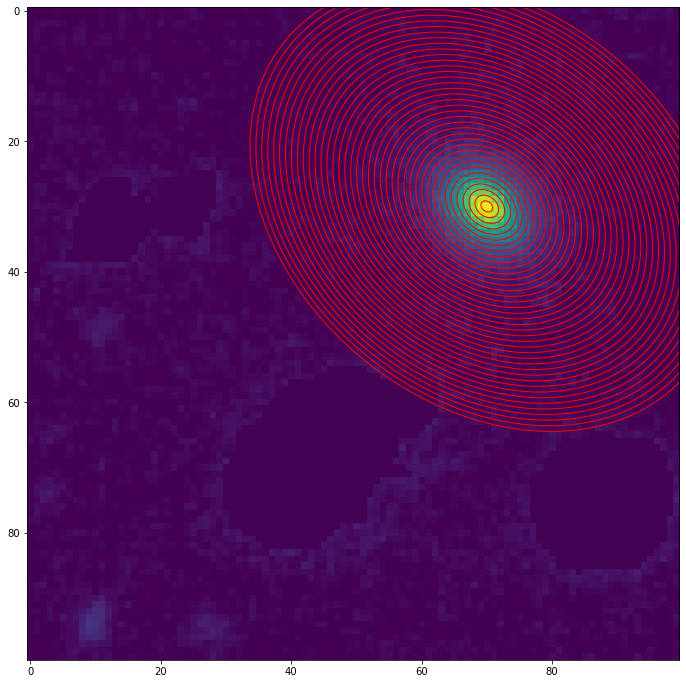

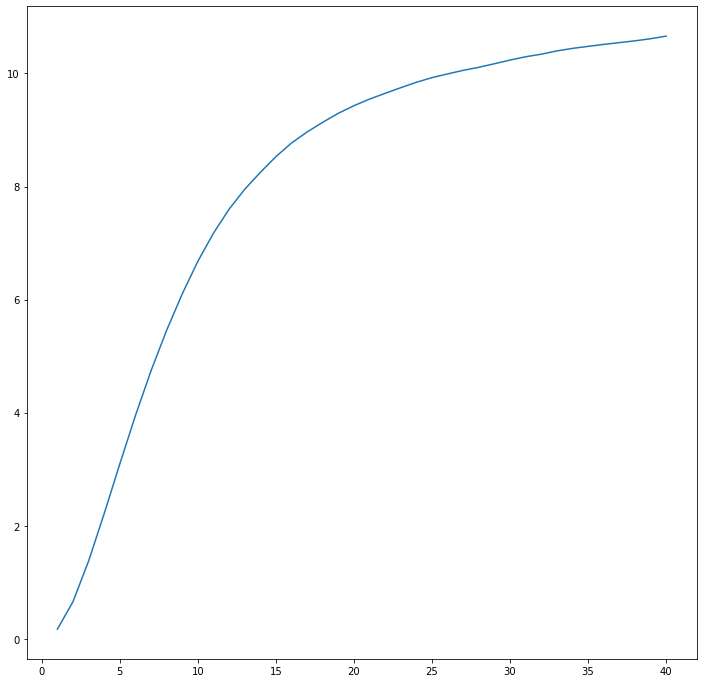

In [16]:
# Test photometry function
obj = cat[0]
aperture_photometry_row = photometry_step(obj, r_list, image, segm_deblend, plot=True, subtract_bg=True)
plt.plot(r_list, aperture_photometry_row)

IntProgress(value=0, description='Loading:', max=6)

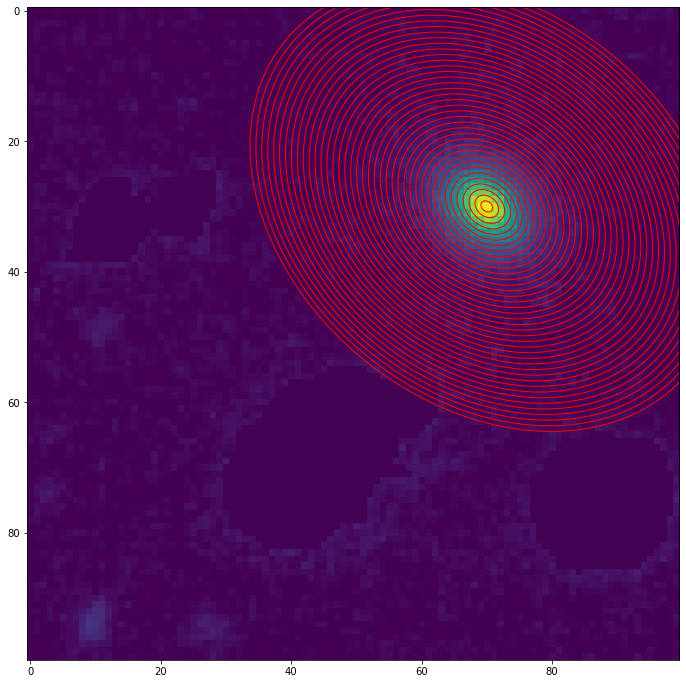

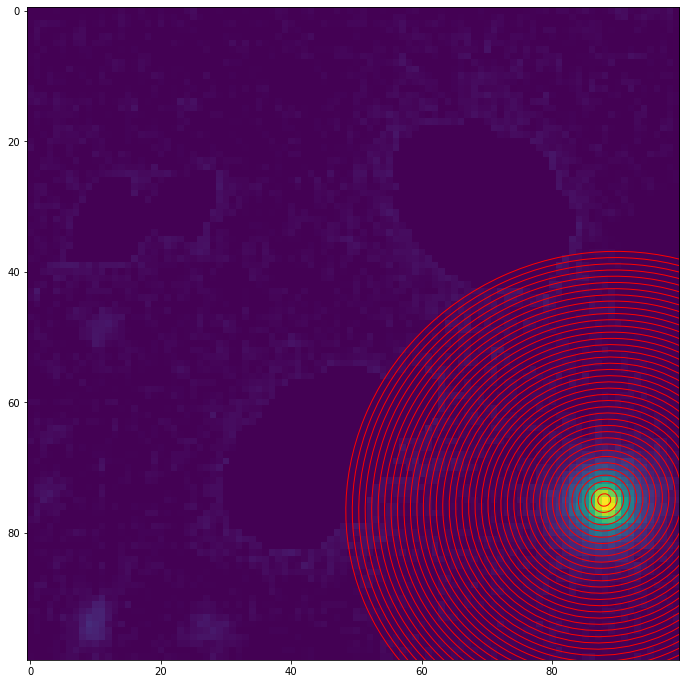

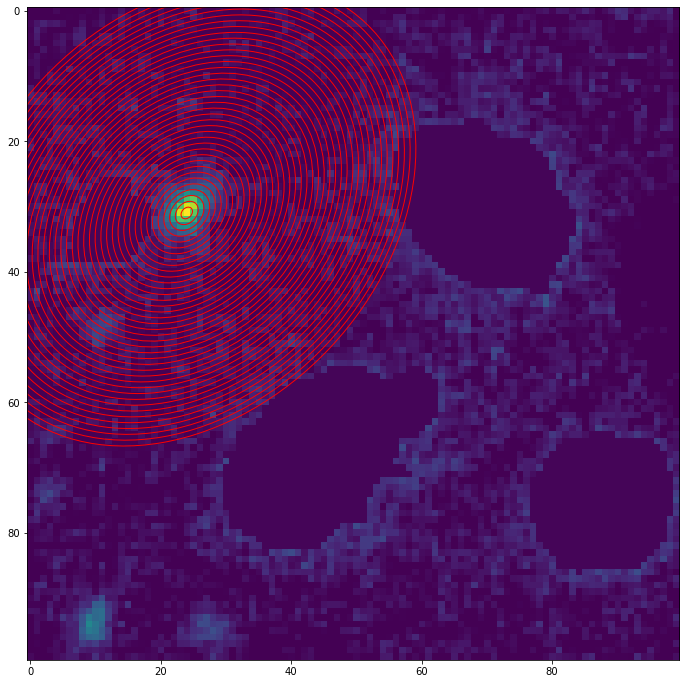

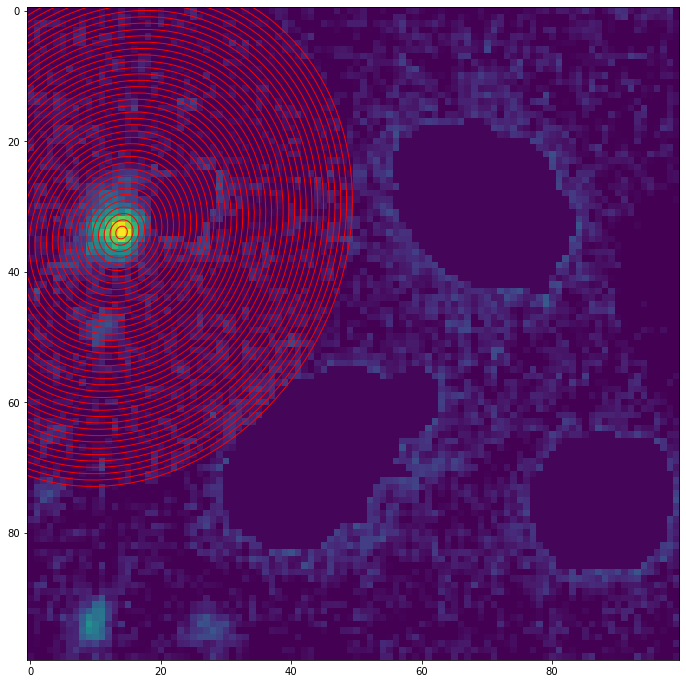

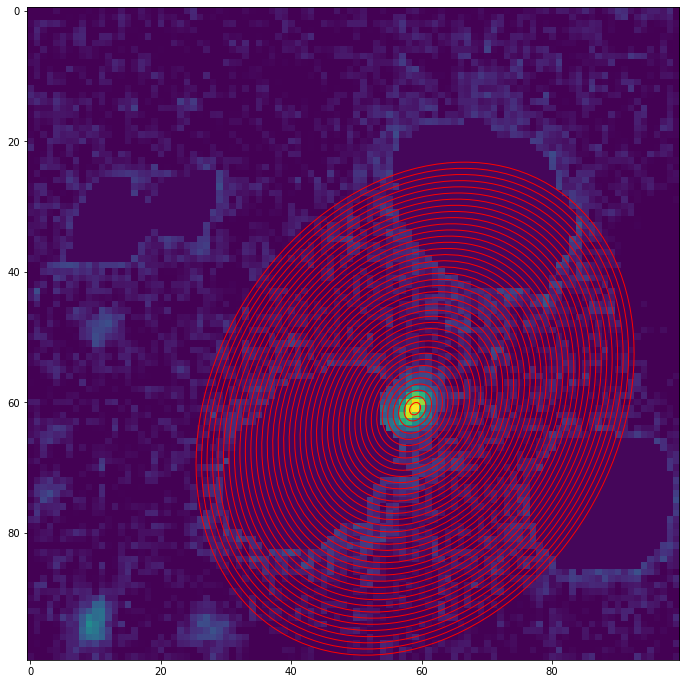

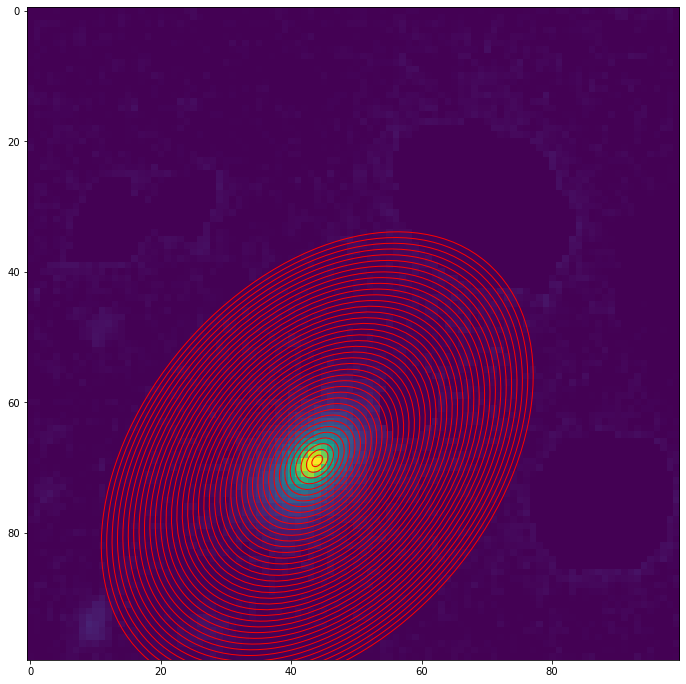

In [17]:
# Photomerty
# ----------
pb = widgets.IntProgress(
    value=0,
    min=0,
    max=len(cat),
    step=1,
    description='Loading:',
    bar_style='',
    orientation='horizontal'
)
display(pb)

single_aperture_photometry_table = cat.to_table()

aperture_photometry_rows = []
for idx, obj in enumerate(cat):
    pb.value = idx + 1
    pb.description = "{}/{}".format(pb.value, len(cat))
    
    aperture_photometry_row = photometry_step(obj, r_list, image, segm_deblend, plot=True, subtract_bg=True)
    aperture_photometry_rows.append(np.array(aperture_photometry_row))

single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
plt.show()

In [18]:
result_cat = Table.read(output_path)
result_cat.sort(keys="source_sum", reverse=1)
result_cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_001,aperture_sum_023,aperture_sum_024,aperture_sum_025,aperture_sum_026,aperture_sum_027,aperture_sum_028,aperture_sum_029,aperture_sum_022,aperture_sum_030,aperture_sum_032,aperture_sum_033,aperture_sum_034,aperture_sum_035,aperture_sum_036,aperture_sum_037,aperture_sum_038,aperture_sum_031,aperture_sum_021,aperture_sum_020,aperture_sum_019,aperture_sum_002,aperture_sum_003,aperture_sum_004,aperture_sum_005,aperture_sum_006,aperture_sum_007,aperture_sum_008,aperture_sum_009,aperture_sum_010,aperture_sum_011,aperture_sum_012,aperture_sum_013,aperture_sum_014,aperture_sum_015,aperture_sum_016,aperture_sum_017,aperture_sum_018,aperture_sum_039,aperture_sum_040
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6,43.23304262690969,69.26788436879689,"3.579727963279084,-30.379536985046332","3.5797249288415247,-30.37953916275188",11.375833,None,None,None,None,30.0,58.0,55.0,82.0,0.0010245082,0.1311228,30.0,71.0,44.0,69.0,547.0,13.195283541573993,95.01219330881976,5.569741142112927,3.7588864182804365,-49.51441939932589,0.7379308569017452,0.3251236776769716,1.481752977431251,21.250115688444964,-8.341739395359156,23.901127807233582,0.05452930537637242,0.03806257667238539,0.04848114519967404,0.5279995995788166,0.2642003874830126,11.913690235542692,11.995339336746673,12.058289037992164,12.107783640087042,12.149567687696754,12.213478558420796,12.290879955866135,11.824192067692563,12.37142993587872,12.536153114998301,12.620441076986303,12.700952111263826,12.781670262646974,12.855123978614694,12.906847465893215,12.932980459696397,12.453726144343472,11.714549530491793,11.603873460432244,11.484423236247636,0.9880606699740219,2.004641794115253,3.1392268522162508,4.288545425351154,5.381749941925107,6.375903536349727,7.257707194054472,8.015789451876527,8.67362603373591,9.246463879274884,9.748695649751054,10.165949822894135,10.510644534410108,10.798456692876513,11.025016082839079,11.209688117955404,11.354715344166284,12.95437079952188,12.991269785346784
1,69.53388361147823,30.11873914166307,"3.5792198220240343,-30.380189451703377","3.5792167876619847,-30.380191629459254",8.787966,None,None,None,None,56.0,83.0,17.0,43.0,0.002057447,0.07657248,67.0,17.0,70.0,30.0,551.0,13.243441670776848,89.84062043356593,5.577609744029219,4.201742028578012,39.63053719183011,0.6576506445820657,0.24667694202235302,1.3274517345646848,25.635754986744814,6.609723832895224,23.128611544663748,0.04211090201577586,-0.024069013580074468,0.04667572734586923,0.47236406642725115,0.17362830856243935,9.747857182293743,9.842870121122758,9.925994495625915,9.991400339885978,10.054680171268027,10.108372935452893,10.171278928285892,9.648366916526548,10.236405159250227,10.340082269793564,10.398206160606794,10.44240937663725,10.478396463550492,10.513188886395632,10.544696297204313,10.57592888084732,10.294792254817647,9.546233006557186,9.429519944074803,9.295093148886767,0.6596185832857792,1.3774931800801073,2.217928779487836,3.0957252239407707,3.949210937905072,4.743232320028515,5.4578678405709535,6.102086448747619,6.678230266577882,7

In [19]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

mag_col_names = natural_sort([i for i in result_cat.colnames if "aperture_sum_" in i])

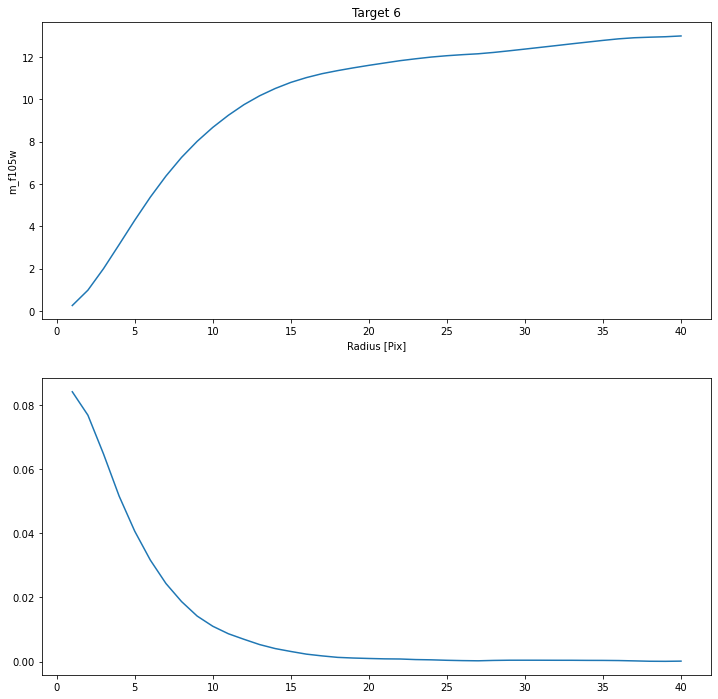

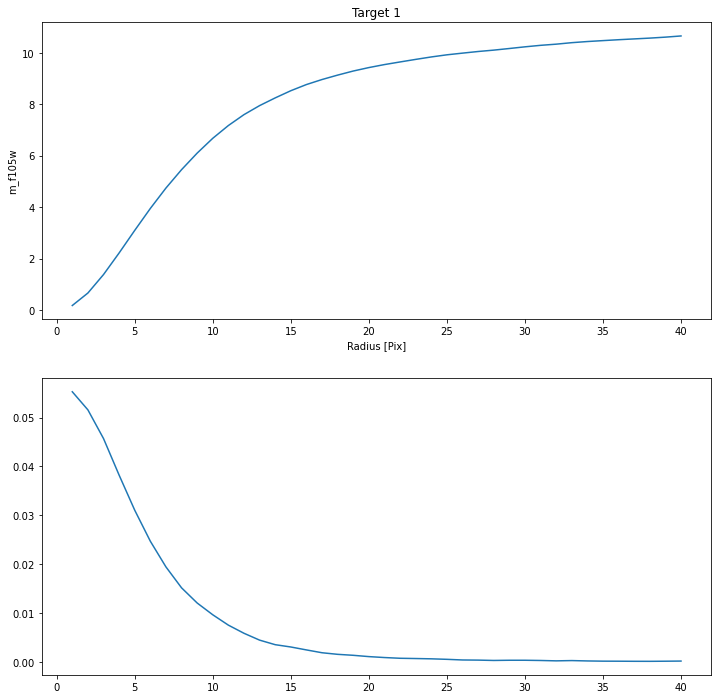

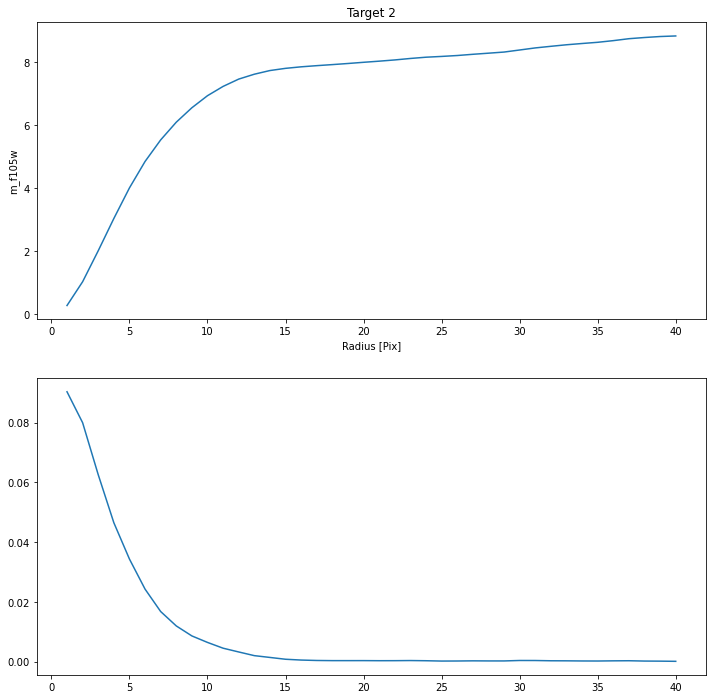

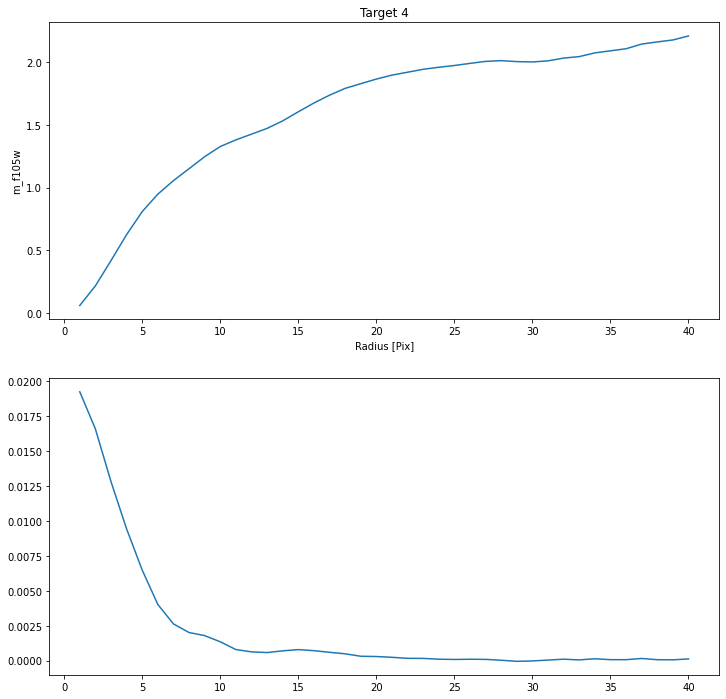

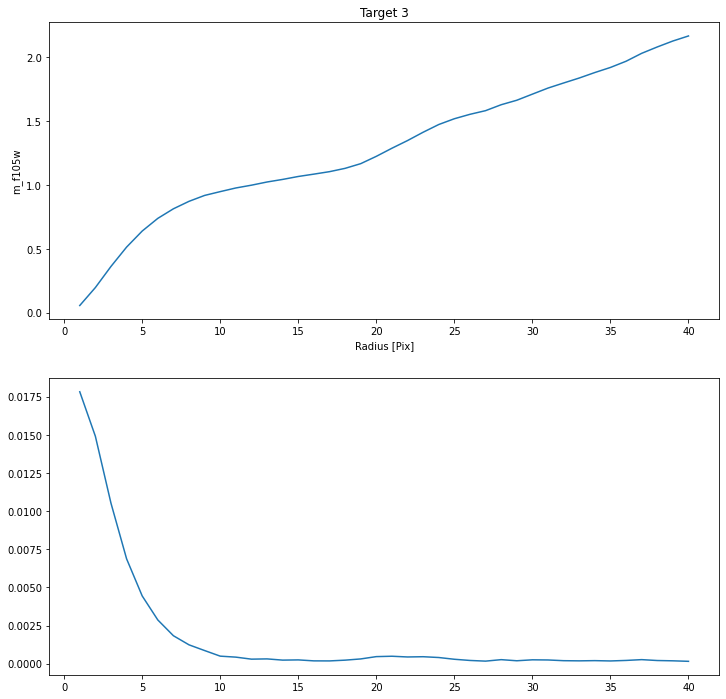

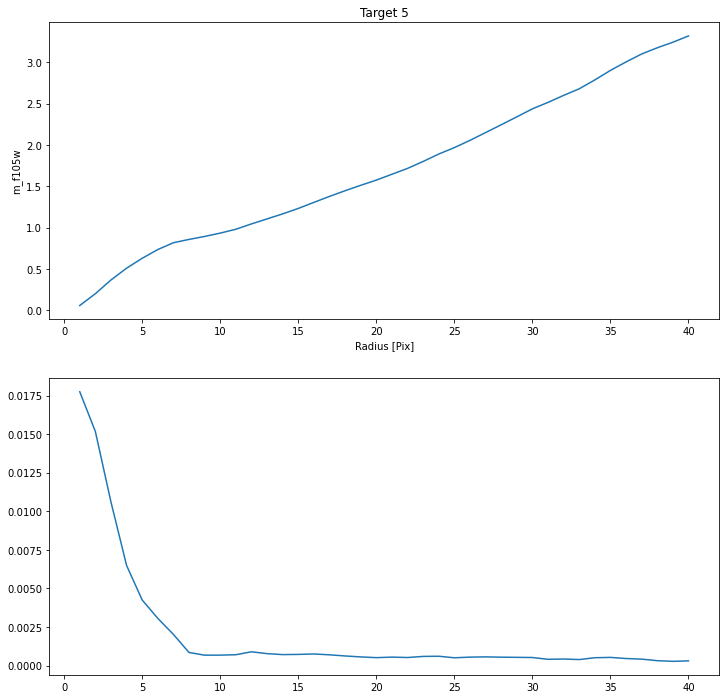

In [20]:
for idx, row in enumerate(result_cat):
    mags = list(row[mag_col_names])
    
    f, ax = plt.subplots(2, 1)
    
    ax[0].plot(r_list, mags)
    ax[0].set_title("Target "+str(row['id']))
    ax[0].set_xlabel("Radius [Pix]")
    ax[0].set_ylabel("m_f105w")
    
    y_values = []
    for i in range(len(mags)):
        if i == 0:
            y_values.append(mags[i]/(np.pi*r_list[i]**2))
            continue
        y_values.append((mags[i] - mags[i-1])/(np.pi*(r_list[i]**2-r_list[i-1]**2)))    
    ax[1].plot(r_list, y_values, label="Raw")
    plt.show()
    if idx == 10:
        break
    print("\n"*2)

In [21]:
def calculate_petrosian(phot_values, r_list):
    petrosian_list = []
    last_r = 0
    last_I = 0
    for i in range(len(r_list)):
        r = r_list[i]
        I = phot_values[i]
        
        area_of_slice = (np.pi * (r**2 - last_r**2))
        I_at_r = (I - last_I) / area_of_slice 
        
        area_within_r = (np.pi * r**2)
        I_avg_within_r = (I / area_within_r)
        
        petrosian_value = I_at_r / I_avg_within_r
        
        petrosian_list.append(petrosian_value)
        
        last_r = r
        last_I = I 
        
    return petrosian_list

In [23]:
def slider(x):
    row = result_cat[x]
    obj = cat[row['id']-1]
    masked_image = masked_segm_image(obj, image, segm_deblend)
    
    size = max(r_list)
    x, y = row['maxval_xpos'], row['maxval_ypos']
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(image.data, vmin=vmin, vmax=vmax)
    ax[0,0].set_xlim(x-size, x+size)
    ax[0,0].set_ylim(y-size, y+size)
    ax[0,0].set_title("Target".format(vmax))
    
    ax[0,1].imshow(masked_image.data, vmin=vmin, vmax=vmax)
    ax[0,1].set_xlim(x-size, x+size)
    ax[0,1].set_ylim(y-size, y+size)
    ax[0,1].set_title("Target [Masked Image]")    
    
    position = [x, y]
    
    for r in r_list:
        CircularAperture(position, r=r).plot(ax[0,0], color='w')
        CircularAperture(position, r=r).plot(ax[0,1], color='w')
    CircularAnnulus(position, r_in=r_list[-1], r_out=r_list[-1]*2).plot(ax[0,0], color='r')
    CircularAnnulus(position, r_in=r_list[-1], r_out=r_list[-1]*2).plot(ax[0,1], color='r')


    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(r_list, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = list(row[mag_col_names])
    for i in range(len(r_list)):
        if i == 0:
            y_values.append(phot_values[i]/(np.pi*r_list[i]**2))
            continue
        y_values.append((phot_values[i] - phot_values[i-1])/(np.pi*(r_list[i]**2 - r_list[i-1]**2)))    
    ax[1,1].plot(r_list, y_values, label="Raw") 
  
    ax[1,1].set_title("Photometic Density: sum(slice) / area(slice)")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Sum")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    '''
    y_values = list(row[mag_col_names])
    plt.plot(r_list, y_values, label="Raw")
    
    plt.title("Cumulative Photometry")
    plt.xlabel("Aperture Radius [Pix]")
    plt.ylabel("Photometic Sum")
    
    plt.legend()
    plt.show()
    '''
    
    petrosian_number = 0.2
    petrosian_list = calculate_petrosian(row[mag_col_names], r_list)

    f = interp1d(r_list, petrosian_list, kind='cubic')

    r_list_new = np.linspace(min(r_list), max(r_list), num=101, endpoint=True)
    petrosian_list_new = f(r_list_new)

    plt.plot(r_list, petrosian_list, 'o', r_list_new, f(r_list_new), '-')

    idx = abs(petrosian_list_new - petrosian_number).argmin()
    r_petrosian = r_list_new[idx]

    plt.axvline(r_petrosian, linestyle='--')
    plt.axhline(petrosian_list_new[idx], xmax=r_petrosian, linestyle='--')

    plt.legend(['data', 'Interpolated [cubic]', "r_petrosian={:0.4f} pix".format(r_petrosian)], loc='best')
    
    plt.title("Petrosian")
    plt.xlabel("Aperture Radius [Pix]")
    plt.ylabel("Petrosian Value")

    plt.show()
    

widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=5), Output()), _dom_classes=('widget-intera…

In [69]:
def slider(x):
    petrosian_list =  calculate_petrosian(result_cat[x][mag_col_names], r_list)
    plt.plot(r_list, petrosian_list)
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));


interactive(children=(BoundedIntText(value=0, description='x', max=5), Output()), _dom_classes=('widget-intera…

In [ ]:
# Old code
"""
for current_filter in  filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 1000)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    #nsigma = np.zeros_like(image) + image.mean() / 3
    nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    #plot_segments(segm_deblend, image)
    
    segm_deblend.remove_border_labels(50)

    cat = source_properties(image, segm_deblend, wcs=image_wcs)
    
    # Photomerty
    # ----------
    plot = False
    r_list = list(range(1, 41, 1))
    #r_list = np.logspace(np.log10(0.06),np.log10(14), 50) * u.arcsec # approximate isophotal extent
    #r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
    #r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

    single_aperture_photometry_table = cat.to_table()

    aperture_photometry_rows = []

    pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(cat),
        step=1,
        description='Loading:',
        bar_style='',
        orientation='horizontal'
    )

    display(pb)

    for idx, obj in enumerate(cat):
        pb.value = idx + 1
        pb.description = "{}/{}".format(pb.value, len(cat))
        
        cut = obj.segment.make_cutout(image, masked_array=True)
        cy, cx = np.unravel_index(cut.argmax(), cut.shape)

        x = obj.segment.bbox.ixmin + cx
        y = obj.segment.bbox.iymin + cy

        #x = obj.xcentroid.value
        #y = obj.ycentroid.value
        single_aperture_photometry_table[idx]['xcentroid'] = x * u.pix
        single_aperture_photometry_table[idx]['ycentroid'] = y * u.pix

        position = np.transpose((x, y))
        
        mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == obj.id))
        masked_image = image.copy()
        masked_image[np.invert(mask)] = np.nan

        annulus = CircularAnnulus(position, r_list[-1], r_list[-1]*2)

        annulus_mask = annulus.to_mask(method='center')
        annulus_data = annulus_mask.multiply(masked_image)
        annulus_data_1d = annulus_data[(annulus_mask.data > 0) & (np.invert(np.isnan(annulus_data)))]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        
        masked_image[np.invert(mask)] =  median_sigclip

        aperture_photometry_row = []

        if plot:
            f, ax = plt.subplots(1, 1)
        for i, r in enumerate(r_list):

            aperture = CircularAperture(position, r)

            photometric_sum = aperture.do_photometry(masked_image, mask=None)[0][0] 
            
            #photometric_bkg = aperture.area * (annulus.do_photometry(masked_image)[0][0] / annulus.area)
            photometric_bkg = median_sigclip * aperture.area

            photometric_value = photometric_sum - photometric_bkg

            if plot:
                ax.imshow(masked_image, vmin=0, vmax=image.mean())
                aperture.plot(ax, color='r')

            aperture_photometry_row.append(photometric_value)
        if plot:
            plt.show()

        aperture_photometry_rows.append(np.array(aperture_photometry_row))

    single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])

    single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    plt.show()
    break
print("done")
"""; 